In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from keras.utils.vis_utils import plot_model

In [3]:
def saveModel(model, filename):
    model.save(filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

In [4]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)

In [5]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [6]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]

In [7]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [8]:
X = StandardScaler().fit_transform(X)
#X = PCA().fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0, stratify=y)

In [10]:
def createModel():
    model = Sequential([
                    Dense(256, input_dim=X.shape[1], activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                   ])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [11]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

In [12]:
def trainEvaluate(model, fold, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=20, verbose=0)
    pred = model.predict(X_test)
    pred = pred >= 0.5
    f1 = f1_score(y_test, pred)
    print(f"F1 Score in fold {fold} = {f1}")
    return f1

def crossValidation(K=10):
    kFold = KFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average {K}-Fold F1 Score = {np.mean(f1_scores)}\n")
    
    k_ctr = 1
    kFold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average Stratified {K}-Fold F1 Score = {np.mean(f1_scores)}")

In [13]:
crossValidation(K=10)

F1 Score in fold 1 = 0.9683257918552036
F1 Score in fold 2 = 0.9766355140186916
F1 Score in fold 3 = 0.970917225950783
F1 Score in fold 4 = 0.9711751662971174
F1 Score in fold 5 = 0.9766355140186914
F1 Score in fold 6 = 0.9834710743801653
F1 Score in fold 7 = 0.9751037344398341
F1 Score in fold 8 = 0.974025974025974
F1 Score in fold 9 = 0.9898580121703854
F1 Score in fold 10 = 0.970917225950783
Average 10-Fold F1 Score = 0.975706523310763

F1 Score in fold 1 = 0.9741379310344828
F1 Score in fold 2 = 0.9823788546255506
F1 Score in fold 3 = 0.9555555555555555
F1 Score in fold 4 = 0.9691629955947135
F1 Score in fold 5 = 0.971677559912854
F1 Score in fold 6 = 0.9912663755458515
F1 Score in fold 7 = 0.9868995633187773
F1 Score in fold 8 = 0.9739130434782608
F1 Score in fold 9 = 0.9803063457330414
F1 Score in fold 10 = 0.9734513274336283
Average Stratified 10-Fold F1 Score = 0.9758749552232715


In [14]:
model = createModel()
model.fit(X_train, y_train, epochs=20, verbose=0)
pred = model.predict(X_test)
pred = pred >= 0.5

In [15]:
performance(y_test, pred)

F1 Score: 0.9735449735449735
Kappa Score: 0.9605071638969944
Accuracy Score: 0.9802535819484972
Confusion Matrix:
[[1514   20]
 [  20  736]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.97      0.97      0.97       756

    accuracy                           0.98      2290
   macro avg       0.98      0.98      0.98      2290
weighted avg       0.98      0.98      0.98      2290



In [16]:
saveModel(model, "../model/nn-model.h5")

In [17]:
model_perm = KerasClassifier(build_fn=createModel, epochs=20, verbose=0)
model_perm.fit(X, y)
perm = PermutationImportance(model_perm, random_state=0).fit(X,y)

In [18]:
eli5.explain_weights(perm, feature_names = TO_USE)

Weight,Feature
0.1362 ± 0.0020,koi_fpflag_ss
0.1273 ± 0.0040,koi_fpflag_co
0.1097 ± 0.0081,koi_fpflag_nt
0.0641 ± 0.0029,koi_fpflag_ec
0.0532 ± 0.0008,koi_duration
0.0521 ± 0.0013,koi_depth
0.0475 ± 0.0038,koi_teq
0.0324 ± 0.0024,koi_period
0.0255 ± 0.0034,koi_slogg
0.0229 ± 0.0015,koi_steff


In [19]:
perm.feature_importances_

array([0.00438105, 0.13615795, 0.10972764, 0.1272806 , 0.05317771,
       0.00132585, 0.00562042, 0.00438105, 0.00080703, 0.06407264,
       0.02285632, 0.00077822, 0.04749963, 0.05214009, 0.03242544,
       0.00628334, 0.02545036, 0.00360285, 0.01072202])

In [20]:
order = np.argsort(perm.feature_importances_)[::-1]
sorted_importances = sorted(perm.feature_importances_, reverse = True)
sorted_features = np.asarray(TO_USE)[order]
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = sorted_features
feature_importance_df['Importance'] = sorted_importances

In [21]:
feature_importance_df.head()

,Features,Importance
0,koi_fpflag_ss,0.136158
1,koi_fpflag_co,0.127281
2,koi_fpflag_nt,0.109728
3,koi_fpflag_ec,0.064073
4,koi_duration,0.053178


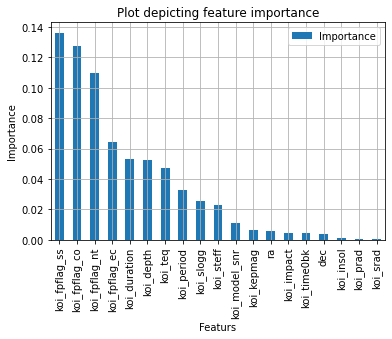

In [22]:
feature_importance_df.plot(x = 'Features', y = 'Importance', kind = 'bar')
plt.title('Plot depicting feature importance')
plt.grid()
plt.xlabel('Featurs')
plt.ylabel('Importance')
plt.savefig("feat_imp_nn.png", dpi=600)
plt.show()

In [23]:
model = createModel()
x=plot_model(model, show_shapes=True)